# Helping Python Script - Gravity

### This Python script is only for inspriation, and you would need to change the parameters, load the a proper dataset, and do your own processing for it to be correct.

### For this script I use the module cartopy

In [6]:
#%% Modules
import numpy as np
import matplotlib.pyplot as plt

# The module cartopy is not part of the standard Python modules, and you would have to include it in your enviroment.
# there is other modules that can do similar to cartopy, feel free to use those insted if desired. 
import cartopy.crs as crs

# Other modules that can be helpfull to know off, scipy.fft are used in the functions "Gauss2Dconv_v1" and "griddata" is usefull later
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.interpolate import griddata


In [7]:
#%% Parameters

#%% For image plot
# Here I generate some random values. When a real dataset is loaded use that insted.
Images_random_values = np.random.rand(100,100)

latlon_area_of_interest = [-15, 40, 45, 70] # min-max of latitude and longitude for dataset
latlon_data_extend = [  4,  7, 54, 57] # min-max of latitude and longitude for the wanted area to see

#%% For scatter plot
scatter_random_values = np.array([np.random.uniform(low=latlon_data_extend[0], high=latlon_data_extend[1], size=(1000,)), 
                                  np.random.uniform(low=latlon_data_extend[2], high=latlon_data_extend[3], size=(1000,)), 
                                  np.random.rand(1000)]).T



c:\Users\Aram\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


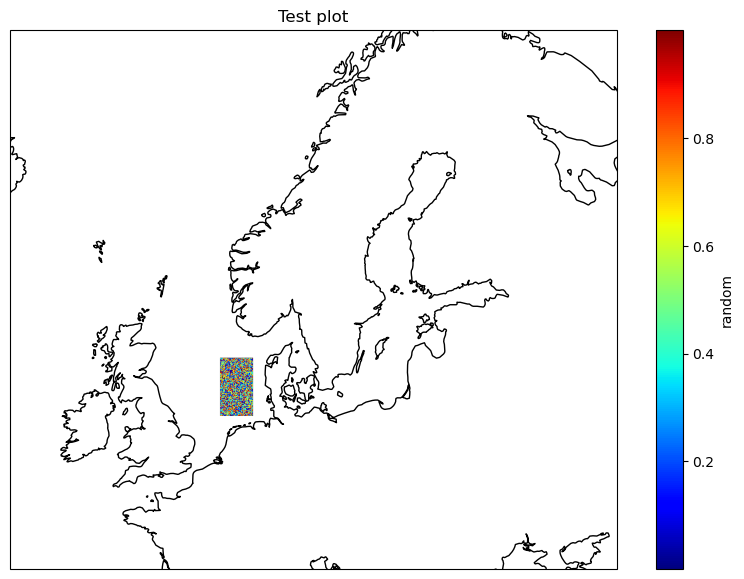

In [8]:
# Image plot
fig, axs = plt.subplots(1,1, figsize=(10, 7), 
                        sharex=True, sharey=True,
                        subplot_kw={'projection': crs.Mercator()})

axs.coastlines() # add costline
axs.set_extent(latlon_area_of_interest, crs=crs.PlateCarree()) # area of interest, this is the extend we see


im = axs.imshow(Images_random_values, 
            extent=latlon_data_extend, 
            origin='lower',
            cmap='jet',
            transform=crs.PlateCarree())

axs.set_title('Test plot')


h = plt.colorbar(im, ax=axs)
h.set_label('random')

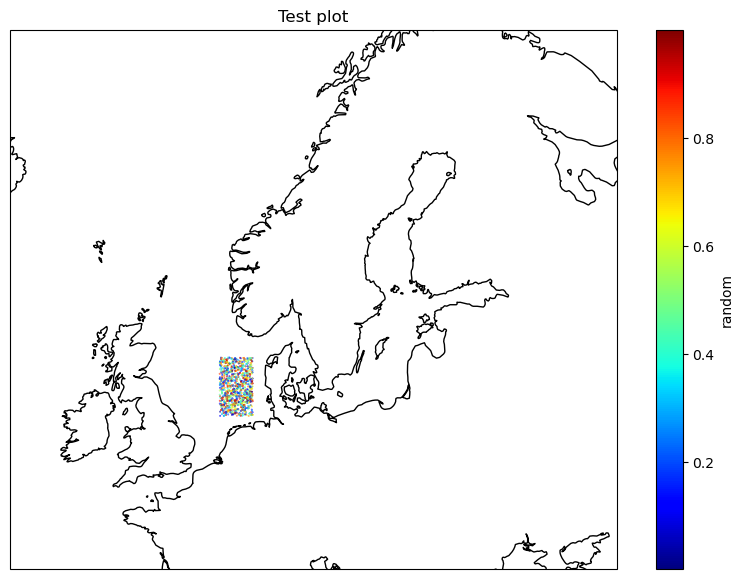

In [9]:
# scatter plot
fig, axs = plt.subplots(1,1, figsize=(10, 7), 
                        sharex=True, sharey=True,
                        subplot_kw={'projection': crs.Mercator()})

axs.coastlines() # add costline
axs.set_extent(latlon_area_of_interest, crs=crs.PlateCarree()) # area of interest, this is the extend we see


im = axs.scatter(x=scatter_random_values[:,0], y=scatter_random_values[:,1], c=scatter_random_values[:,2],
                 s=0.1, # size of dot
                 cmap='jet',
                 transform=crs.PlateCarree())

axs.set_title('Test plot')


h = plt.colorbar(im, ax=axs)
h.set_label('random')

### Some extra help:

#### - How to load "db.dat"
#### - How to use griddata
#### - How to include Python script and call function


In [14]:
#%% How to load "db.dat"

data = np.loadtxt("db.dat")

# to acces columns 
Measurements_number = data[:,0]
Latitude = data[:,1]
Longitude = data[:,2]
Gravity = data[:,4]



In [15]:
# How to use griddata

grid_x, grid_y = np.mgrid[latlon_data_extend[0]:latlon_data_extend[1]:100j, latlon_data_extend[2]:latlon_data_extend[3]:100j]
grided_data = griddata(scatter_random_values[:,:2], scatter_random_values[:,2], (grid_x, grid_y), method='linear')

In [23]:
# How to include Python script and call function

# import function
from Gauss2Dconv_v1 import Gauss2Dconv_v1

# call function
g_low, g_high = Gauss2Dconv_v1(grid_y, grid_x, grided_data, 1)


In [67]:

ano_peak_idx = np.unravel_index(np.argmax(g_high), g_high.shape)
temp_lon = grid_x[ano_peak_idx]
temp_lat = grid_y[ano_peak_idx]


center_lon = temp_lon   
center_lat = temp_lat 

print("Center of anomaly:")
print("Latitude =", center_lat)
print("Longitude =", center_lon)


lat_span = 0.08
n_points = 400

lat_start = center_lat - lat_span
lat_end = center_lat + lat_span

profile_lat = np.linspace(lat_start, lat_end, n_points)
profile_lon = np.full_like(profile_lat, center_lon)

profile_NS = np.column_stack((profile_lon, profile_lat))



Center of anomaly:
Latitude = 54.93939393939394
Longitude = 6.151515151515151


In [68]:
profile_lons = profile_NS[:, 0]
profile_lats = profile_NS[:, 1]

grid_points = np.column_stack((grid_y.ravel(), grid_x.ravel()))  
grid_values = g_high.ravel()

profile_g = griddata(grid_points, grid_values, 
                     (profile_lats, profile_lons),
                     method='linear')

profile_data = np.column_stack((profile_lons, profile_lats, profile_g))

In [69]:
R_earth = 6371000  
deg_to_rad = np.pi / 180


profile_dist = (profile_lats - center_lat) * deg_to_rad * R_earth


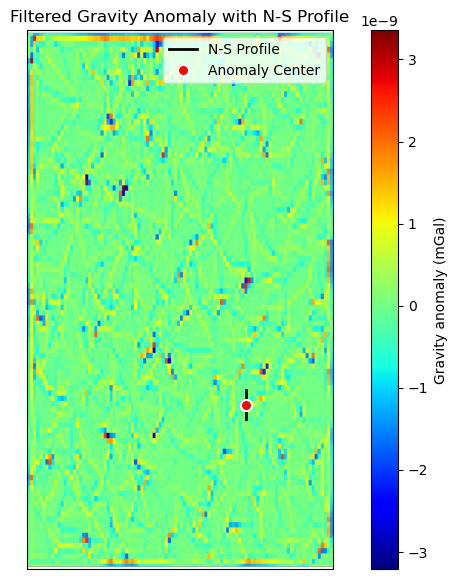

In [70]:
# Visualize the profile location on the filtered gravity map
fig, axs = plt.subplots(1, 1, figsize=(10, 7), 
                        subplot_kw={'projection': crs.Mercator()})

axs.coastlines()
axs.set_extent(latlon_data_extend, crs=crs.PlateCarree())

# Plot the filtered gravity anomaly as background
im = axs.imshow(g_high, 
                extent=latlon_data_extend, 
                origin='lower',
                cmap='jet',
                transform=crs.PlateCarree())

# ✅ Plot the profile line
axs.plot(profile_lon, profile_lat, 'k-', linewidth=2,
         transform=crs.PlateCarree(), label='N-S Profile', zorder=5)

# ✅ SIMPLE DOT: Mark the anomaly center
axs.plot(center_lon, center_lat, 'o', markersize=8,
         color='red', markeredgecolor='white', markeredgewidth=1.5,
         transform=crs.PlateCarree(), label='Anomaly Center', zorder=10)

axs.set_title('Filtered Gravity Anomaly with N-S Profile')
axs.legend(loc='upper right')

h = plt.colorbar(im, ax=axs)
h.set_label('Gravity anomaly (mGal)')
plt.show()

In [71]:
print(f"Center coordinates: lon={center_lon}, lat={center_lat}")
print(f"Data extent: {latlon_data_extend}")
print(f"Is center within extent? lon: {latlon_data_extend[0]} < {center_lon} < {latlon_data_extend[1]}")
print(f"Is center within extent? lat: {latlon_data_extend[2]} < {center_lat} < {latlon_data_extend[3]}")

Center coordinates: lon=6.151515151515151, lat=54.93939393939394
Data extent: [4, 7, 54, 57]
Is center within extent? lon: 4 < 6.151515151515151 < 7
Is center within extent? lat: 54 < 54.93939393939394 < 57
